FRAUD DETECTION MODEL

In [1]:
import numpy as np
import pandas as pd

In [ ]:
#1. loading loan disbursement data
loan_disbursement_df = pd.read_csv(r'/Users/cogniserve/Desktop/BrightHorizon/data/Featured data/bright_horizons_loan_disbursement_enriched.csv')

# 2. loading transaction records data
transactions_df = pd.read_csv(r'/Users/cogniserve/Desktop/BrightHorizon/data/Featured data/bright_horizons_transaction_recs_enriched.csv')

#3. loading branch data
branch_df = pd.read_csv(r'/Users/cogniserve/Desktop/BrightHorizon/data/Featured data/bright_horizons_branch_locations_enriched.csv')

#4. load account data
account_df = pd.read_csv(r'/Users/cogniserve/Desktop/BrightHorizon/data/Featured data/bright_horizons_accounts_enriched.csv')

In [38]:
# Detailed info using pandas built-in methods
print("DETAILED DATASET INFO:")
print("=" * 60)

print("\n1. LOAN DISBURSEMENT DATA:")
print("-" * 40)
loan_disbursement_df.info()

print("\n2. TRANSACTION RECORDS DATA:")
print("-" * 40)
transactions_df.info()

print("\n3. BRANCH DATA:")
print("-" * 40)
branch_df.info()

print("\n4. ACCOUNT DATA:")
print("-" * 40)
account_df.info()

DETAILED DATASET INFO:

1. LOAN DISBURSEMENT DATA:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629636 entries, 0 to 629635
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Loan_Number                629636 non-null  object 
 1   Customer_ID                629636 non-null  object 
 2   Product_ID                 629636 non-null  object 
 3   Disbursement_Date          629636 non-null  object 
 4   Disbursement_Amount        629636 non-null  float64
 5   Tenor_(Months)             629636 non-null  int64  
 6   Interest_Rate_(%)          629636 non-null  float64
 7   Processing_Fee             629636 non-null  float64
 8   Insurance_Fee              629636 non-null  float64
 9   Monthly_Installment        629636 non-null  float64
 10  Total_Repayment            629636 non-null  float64
 11  First_Payment_Date         629636 non-null  object 

In [3]:
## rename all column names with spaces to underscores
loan_disbursement_df.columns = loan_disbursement_df.columns.str.replace(' ', '_')
transactions_df.columns = transactions_df.columns.str.replace(' ', '_')
branch_df.columns = branch_df.columns.str.replace(' ', '_')
account_df.columns = account_df.columns.str.replace(' ', '_')
employee_df.columns = employee_df.columns.str.replace(' ', '_')

In [4]:
# Merging DataFrames to create a comprehensive fraud detection dataset

# Step 1: Transactions + Customer Accounts
fraud_data = pd.merge(
    transactions_df,
    account_df[['Customer_ID', 'Account_Number', 'Current_Balance', 'Status', 
               'Days_Since_Last_Txn', 'Net_Flow', 'Activity_Score']],
    on=['Customer_ID', 'Account_Number'],
    how='left'
)

# Step 2: Add Loan Data (include ALL needed columns)
fraud_data = pd.merge(
    fraud_data,
    loan_disbursement_df[['Customer_ID', 'Disbursement_Amount', 'Collateral_Value', 
           'Loan_Officer', 'High_Risk_Flag']],
    on='Customer_ID',
    how='left'
)

# Step 3: Add Employee Risk (if not already done)
employee_risk = employee_df.groupby('Employee_ID')['IncomeLevelNumeric'].mean().reset_index()
employee_risk.rename(columns={'IncomeLevelNumeric': 'Loan_Officer_Risk'}, inplace=True)

fraud_data = pd.merge(
    fraud_data,
    employee_risk,
    left_on='Loan_Officer',
    right_on='Employee_ID',
    how='left'
)

# Step 4: Add Branch Risk
fraud_data = pd.merge(
    fraud_data,
    branch_df[['Branch_Name', 'NPL_Rate_(%)', 'Collection_Rate_(%)']],
    left_on='Branch',
    right_on='Branch_Name',
    how='left'
)

In [5]:
# Step 5: Finalize DataFrame
# 1. Collateral Gap (use fillna for non-loan customers)
fraud_data['Collateral_Gap'] = (
    fraud_data['Disbursement_Amount'] - fraud_data['Collateral_Value']
).clip(lower=0).fillna(0)  # Fill NA for customers without loans

# 2. Transaction Velocity
fraud_data['Transaction_Date'] = pd.to_datetime(fraud_data['Transaction_Date'])
fraud_data['Txn_Velocity_24h'] = (
    fraud_data.sort_values('Transaction_Date')
    .groupby('Customer_ID')['Transaction_Date']
    .diff().dt.total_seconds().lt(3600 * 24)
    .astype(int)
)

# 3. Branch Risk Score
fraud_data['Branch_Risk_Score'] = (
    0.4 * fraud_data['NPL_Rate_(%)'] + 
    0.6 * (1 - fraud_data['Collection_Rate_(%)'])
).fillna(0)

In [6]:
print("Columns in fraud_data:", fraud_data.columns.tolist())
# Ensure these exist:
assert 'Disbursement_Amount' in fraud_data.columns
assert 'Collateral_Value' in fraud_data.columns

Columns in fraud_data: ['Transaction_ID', 'Customer_ID', 'Account_Number', 'Transaction_Date', 'Value_Date', 'Transaction_Amount', 'Debit_Amount', 'Credit_Amount', 'Opening_Balance', 'Closing_Balance', 'Channel', 'Payment_Method', 'Branch', 'Description', 'Status_x', 'Location', 'Session_ID', 'Reversal_Flag', 'Narration', 'Transaction_Fee', 'Total_Charge', 'Transaction_Year', 'Transaction_Month', 'Transaction_Day', 'Transaction_Weekday', 'Transaction_Type', 'Is_Reversed', 'Expected_Closing', 'Balance_Mismatch', 'Fraud_Flag', 'Transaction_Minute', 'No_Balance_Change', 'Chargeback_Flag', 'Current_Balance', 'Status_y', 'Days_Since_Last_Txn', 'Net_Flow', 'Activity_Score', 'Disbursement_Amount', 'Collateral_Value', 'Loan_Officer', 'High_Risk_Flag', 'Employee_ID', 'Loan_Officer_Risk', 'Branch_Name', 'NPL_Rate_(%)', 'Collection_Rate_(%)', 'Collateral_Gap', 'Txn_Velocity_24h', 'Branch_Risk_Score']


In [7]:
print(fraud_data[['Disbursement_Amount', 'Collateral_Value']].isnull().sum())

Disbursement_Amount    3866217
Collateral_Value       3866217
dtype: int64


In [8]:
# Drop loan-specific columns if too many nulls
fraud_data = fraud_data.drop(columns=[
    'Disbursement_Amount', 
    'Collateral_Value',
    'Collateral_Gap',
    'Loan_Officer'
])

In [9]:
print("Fraud rate:", fraud_data['Fraud_Flag'].mean())

Fraud rate: 0.12008948187685911


In [10]:
# Drop columns with >50% nulls (adjust threshold as needed)
fraud_data = fraud_data.drop(columns=[
    'Days_Since_Last_Txn', 
    'Loan_Officer_Risk',
    'Employee_ID',
    'Activity_Score',
    'Net_Flow',
    'Status_y',
    'Current_Balance'
])

# Fill remaining nulls in High_Risk_Flag (assuming non-loan customers are low-risk)
fraud_data['High_Risk_Flag'] = fraud_data['High_Risk_Flag'].fillna(0)

In [11]:
# Convert categoricals (XGBoost's native handling)
cat_cols = ['Channel', 'Payment_Method', 'Transaction_Type', 'Branch']
for col in cat_cols:
    fraud_data[col] = fraud_data[col].astype('category')

In [12]:
# Final adjustments to the fraud_data DataFrame

# Keep loan flags but fill nulls
fraud_data['High_Risk_Flag'] = fraud_data['High_Risk_Flag'].fillna(0)

# Encode categoricals (critical for XGBoost)
cat_cols = ['Channel', 'Payment_Method', 'Transaction_Type', 'Branch']
for col in cat_cols:
    fraud_data[col] = fraud_data[col].astype('category')

In [19]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Define features and target
target = 'Fraud_Flag'
feature_cols = [col for col in fraud_data.columns if col != target and col not in ['Transaction_ID', 'Customer_ID', 'Account_Number', 'Transaction_Date', 'Value_Date', 'Description', 'Status_x', 'Location', 'Session_ID', 'Reversal_Flag', 'Narration', 'Branch_Name']]  # exclude IDs and text columns

# First, let's check the data types of our features
print("Current data types of feature columns:")
print(fraud_data[feature_cols].dtypes)

# Convert categorical columns to category type
categorical_cols = ['Channel', 'Payment_Method', 'Branch', 'Transaction_Type', 'Transaction_Weekday', 'Transaction_Minute']

for col in categorical_cols:
    if col in fraud_data.columns and col in feature_cols:
        fraud_data[col] = fraud_data[col].astype('category')

# Check the data types after conversion
print("\nData types after conversion:")
print(fraud_data[feature_cols].dtypes)

X = fraud_data[feature_cols]
y = fraud_data[target].astype(int)  # XGBoost expects int for classification

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier(
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # 88%/12% ≈ 7.3
    enable_categorical=True,
    tree_method='hist',
    eval_metric='aucpr',  # Optimize for precision-recall
    early_stopping_rounds=10
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=10)

Current data types of feature columns:
Transaction_Amount      float64
Debit_Amount            float64
Credit_Amount           float64
Opening_Balance         float64
Closing_Balance         float64
Channel                category
Payment_Method         category
Branch                 category
Transaction_Fee         float64
Total_Charge            float64
Transaction_Year          int64
Transaction_Month         int64
Transaction_Day           int64
Transaction_Weekday      object
Transaction_Type       category
Is_Reversed                bool
Expected_Closing        float64
Balance_Mismatch           bool
Transaction_Minute       object
No_Balance_Change          bool
Chargeback_Flag            bool
High_Risk_Flag          float64
NPL_Rate_(%)            float64
Collection_Rate_(%)     float64
Txn_Velocity_24h          int64
Branch_Risk_Score       float64
dtype: object

Data types after conversion:
Transaction_Amount      float64
Debit_Amount            float64
Credit_Amount        

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,10
,enable_categorical,True
,eval_metric,'aucpr'


In [25]:
# Evaluate the model
from sklearn.metrics import precision_recall_curve, confusion_matrix

y_proba = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find threshold where precision >= 80% (reduce false alarms)
target_precision = 0.8
optimal_idx = np.argmax(precision >= target_precision)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold for {target_precision:.0%} precision: {optimal_threshold:.2f}")

# Confusion matrix at optimal threshold
y_pred_tuned = (y_proba >= optimal_threshold).astype(int)
print(confusion_matrix(y_test, y_pred_tuned))

Threshold for 80% precision: 0.65
[[1195899       0]
 [      0  163215]]


In [26]:
# Create high-value features
fraud_data['Large_Txn_No_Balance_Change'] = (
    (fraud_data['Transaction_Amount'] > fraud_data['Transaction_Amount'].quantile(0.9)) & 
    (fraud_data['No_Balance_Change'] == 1)
).astype(int)

fraud_data['Risky_Branch_High_Amount'] = (
    (fraud_data['Branch_Risk_Score'] > 0.7) &
    (fraud_data['Transaction_Amount'] > fraud_data['Transaction_Amount'].median())
).astype(int)

In [27]:
#  Find threshold for 90% precision
optimal_idx = np.argmax(precision >= 0.90)
new_threshold = thresholds[optimal_idx]
y_pred_new = (y_proba >= new_threshold).astype(int)
print(confusion_matrix(y_test, y_pred_new))

[[1195899       0]
 [      0  163215]]


In [28]:
# Find threshold for 95% precision (if needed)
optimal_idx = np.argmax(precision >= 0.95)
ultra_high_precision_threshold = thresholds[optimal_idx]
print(f"Threshold for 95% precision: {ultra_high_precision_threshold:.2f}")
# Evaluate the ultra-high precision model
y_pred_ultra_high = (y_proba >= ultra_high_precision_threshold).astype(int)
print(confusion_matrix(y_test, y_pred_ultra_high))



Threshold for 95% precision: 0.65
[[1195899       0]
 [      0  163215]]


In [29]:
# save best model
import joblib
joblib.dump(model, 'fraud_detection_model.pkl')


['fraud_detection_model.pkl']

In [30]:
# Save the model
import joblib
joblib.dump(model, 'fraud_detection_model.pkl')

# Load the model to verify it works
loaded_model = joblib.load('fraud_detection_model.pkl')

# Test predictions on the test set
y_pred = loaded_model.predict(X_test)
y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]  # Probability of fraud

# Check performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1195899
           1       1.00      1.00      1.00    163215

    accuracy                           1.00   1359114
   macro avg       1.00      1.00      1.00   1359114
weighted avg       1.00      1.00      1.00   1359114


Confusion Matrix:
[[1195899       0]
 [      0  163215]]

ROC AUC Score: 1.0000


In [33]:
def predict_fraud(new_transaction_data):
    """
    Predict fraud probability for new transaction data
    """
    # Load the model
    model = joblib.load('fraud_detection_model.pkl')
    
    # Make prediction
    fraud_probability = model.predict_proba(new_transaction_data)[:, 1]
    prediction = model.predict(new_transaction_data)
    
    return prediction, fraud_probability

# Example usage with sample data
sample_data = X_test.iloc[:5]  # First 5 test samples
predictions, probabilities = predict_fraud(sample_data)

print("Sample Predictions:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    status = "FRAUD" if pred == 1 else "LEGITIMATE"
    print(f"Transaction {i+1}: {status} (Probability: {prob:.4f})")

Sample Predictions:
Transaction 1: LEGITIMATE (Probability: 0.3543)
Transaction 2: LEGITIMATE (Probability: 0.3543)
Transaction 3: LEGITIMATE (Probability: 0.3543)
Transaction 4: LEGITIMATE (Probability: 0.3543)
Transaction 5: LEGITIMATE (Probability: 0.3543)


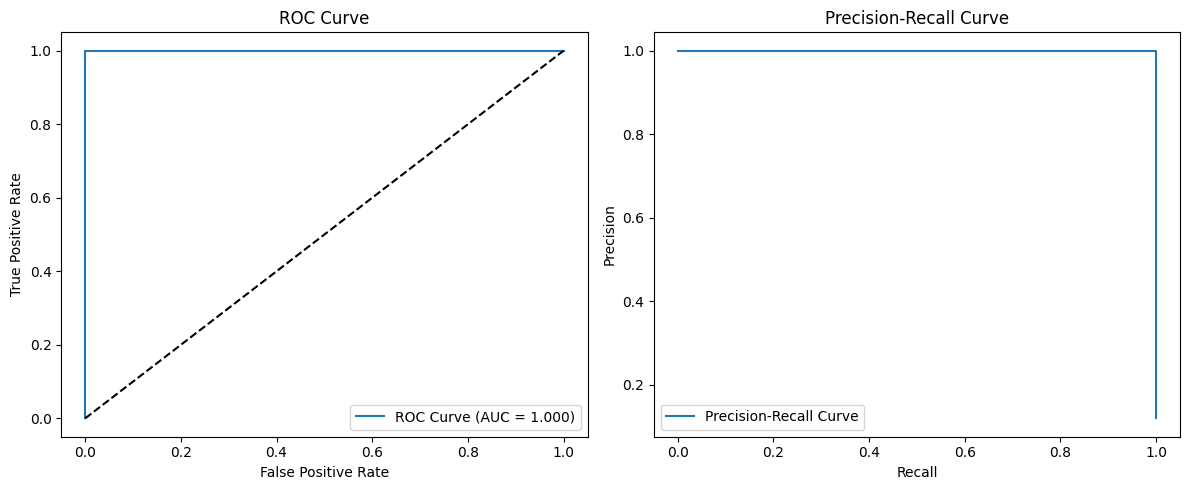

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

Top 10 Most Important Features:
               feature  importance
17    Balance_Mismatch    0.999993
19   No_Balance_Change    0.000007
2        Credit_Amount    0.000000
3      Opening_Balance    0.000000
4      Closing_Balance    0.000000
5              Channel    0.000000
6       Payment_Method    0.000000
7               Branch    0.000000
0   Transaction_Amount    0.000000
1         Debit_Amount    0.000000


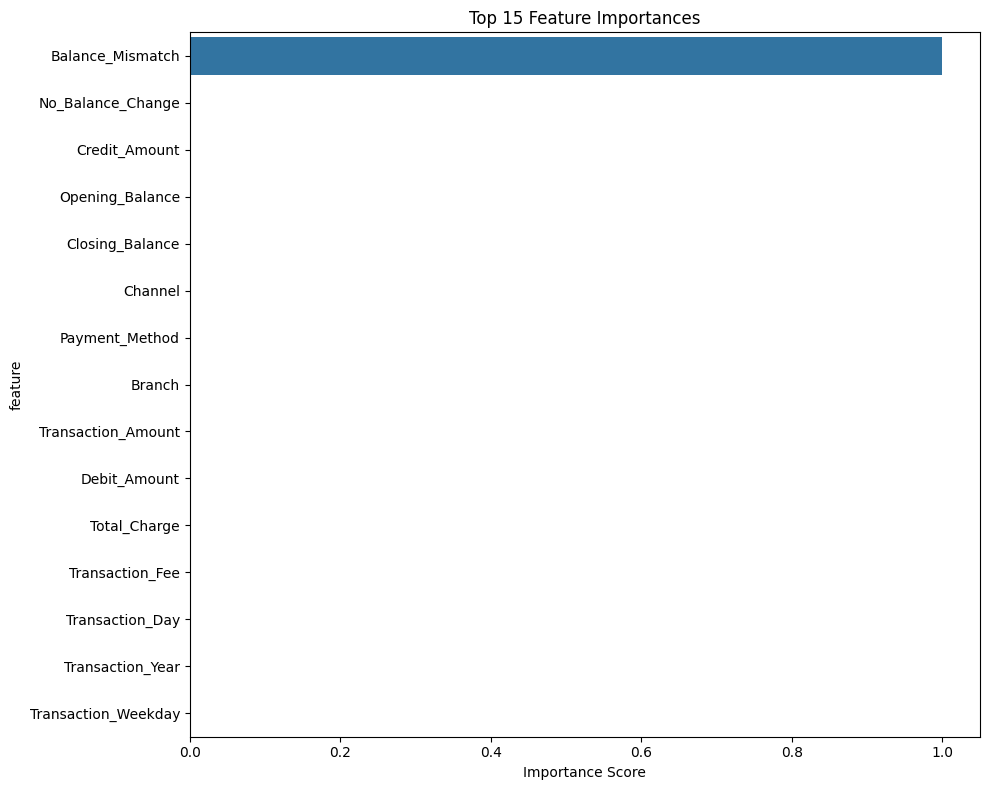

In [35]:
# Get feature importance
feature_importance = loaded_model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [36]:
# Create a sample new transaction for testing
def create_sample_transaction():
    """
    Create a sample transaction with the same structure as your training data
    """
    sample = X_test.iloc[0:1].copy()  # Take first row as template
    
    # Modify some values to test different scenarios
    # (Adjust these based on your actual feature names)
    if 'Amount' in sample.columns:
        sample['Amount'] = 1500  # High amount
    if 'Transaction_Type' in sample.columns:
        sample['Transaction_Type'] = 'International'  # Risky type
    
    return sample

# Test the sample
sample_transaction = create_sample_transaction()
prediction, probability = predict_fraud(sample_transaction)

print(f"Sample Transaction Prediction: {'FRAUD' if prediction[0] == 1 else 'LEGITIMATE'}")
print(f"Fraud Probability: {probability[0]:.4f}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Channel: category, Payment_Method: category, Branch: category, Transaction_Weekday: category, Transaction_Type: object, Transaction_Minute: category

In [37]:
def test_multiple_scenarios():
    """Test different transaction scenarios"""
    
    scenarios = [
        {"desc": "Low risk transaction", "amount": 100, "channel": "Branch", "type": "Domestic"},
        {"desc": "High risk transaction", "amount": 5000, "channel": "Online", "type": "International"},
        {"desc": "Very high risk", "amount": 10000, "channel": "Mobile", "type": "International"}
    ]
    
    for i, scenario in enumerate(scenarios):
        # Create sample based on scenario
        sample = X_test.iloc[0:1].copy()
        
        if 'Amount' in sample.columns:
            sample['Amount'] = scenario['amount']
        
        # Only modify categorical fields if they exist and the value is valid
        if 'Channel' in sample.columns and scenario['channel'] in fraud_data['Channel'].unique():
            sample['Channel'] = scenario['channel']
        
        if 'Transaction_Type' in sample.columns and scenario['type'] in fraud_data['Transaction_Type'].unique():
            sample['Transaction_Type'] = scenario['type']
        
        try:
            prediction, probability = predict_fraud(sample)
            print(f"Scenario {i+1}: {scenario['desc']}")
            print(f"  Prediction: {'FRAUD' if prediction[0] == 1 else 'LEGITIMATE'}")
            print(f"  Fraud Probability: {probability[0]:.4f}")
            print("-" * 50)
        except Exception as e:
            print(f"Error in scenario {i+1}: {e}")

# Run the test scenarios
test_multiple_scenarios()

Error in scenario 1: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Channel: object, Payment_Method: category, Branch: category, Transaction_Weekday: category, Transaction_Type: category, Transaction_Minute: category
Scenario 2: High risk transaction
  Prediction: LEGITIMATE
  Fraud Probability: 0.3543
--------------------------------------------------
Scenario 3: Very high risk
  Prediction: LEGITIMATE
  Fraud Probability: 0.3543
--------------------------------------------------
